In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy
from sklearn.metrics import r2_score
import pmdarima as pm

In [2]:
fileName = 'C:/Users/mcarp/OneDrive/Documents/Monthly NYC Accident Data - Master Sheet.csv'
months = pd.read_csv(fileName)
dfmonthly = pd.DataFrame(months)

In [3]:
largeFile='C:/Users/mcarp/Downloads/Motor_Vehicle_Collisions_-_Crashes.csv'
large_file = pd.read_csv(largeFile)
dfCrash = pd.DataFrame(large_file)

In [153]:
lastFile='C:/Users/mcarp/OneDrive/Documents/Collision Monthly Borough.csv'
_file = pd.read_csv(lastFile)
dfBoroughs = pd.DataFrame(_file)

In [154]:
dfBoroughs['Injuries']=dfBoroughs['MotoristsInjured']+dfBoroughs['PassengersInjured']+dfBoroughs['PedestriansInjured']+dfBoroughs['CyclistsInjured']
dfBoroughs['Injuries/Population'] = dfBoroughs['Injuries']/dfBoroughs['PopEstimate(2019)']
dfBoroughs['Fatalities']=dfBoroughs['MotoristsKilled']+dfBoroughs['PassengersKilled']+dfBoroughs['PedestriansKilled']+dfBoroughs['CyclistsKilled']
dfBoroughs['Fatalities/Population'] = dfBoroughs['Fatalities']/dfBoroughs['PopEstimate(2019)']
dfBoroughs['Cyclist/Pedestrian Injuries']=dfBoroughs['CyclistsInjured']+dfBoroughs['PedestriansInjured']
dfBoroughs['Cyclist/Pedestrian Fatalities']=dfBoroughs['CyclistsKilled']+dfBoroughs['PedestriansKilled']
dfBoroughs['Date'] = dfBoroughs['Month'].astype(str)+'-'+dfBoroughs['Year'].astype(str)
dfBoroughs['Inj_or_fatal_coll_Population']=100000*dfBoroughs['Injury_or_fatal_collisions']/dfBoroughs['PopEstimate(2019)']

In [155]:
dfStat = dfBoroughs[dfBoroughs['Borough']=='STATEN ISLAND']
dfMan = dfBoroughs[dfBoroughs['Borough']=='MANHATTAN']
dfBk = dfBoroughs[dfBoroughs['Borough']=='BROOKLYN']
dfBronx = dfBoroughs[dfBoroughs['Borough']=='BRONX']
dfQueens = dfBoroughs[dfBoroughs['Borough']=='QUEENS']

print(dfStat.shape,dfMan.shape,dfBk.shape,dfBronx.shape,dfQueens.shape)

(110, 22) (110, 22) (110, 22) (110, 22) (110, 22)


In [160]:
dfStat=dfStat.reset_index()
del dfStat['index']
dfMan=dfMan.reset_index()
del dfMan['index']
dfBk=dfBk.reset_index()
del dfBk['index']
dfBronx=dfBronx.reset_index()
del dfBronx['index']
dfQueens=dfQueens.reset_index()
del dfQueens['index']
dfQueens.head(2)

,Year,Month,Borough,PopEstimate(2019),Num_Motor_Vehicle_Collisions,Injury_or_fatal_collisions,MotoristsInjured,MotoristsKilled,PassengersInjured,PassengersKilled,...,PedestriansInjured,PedestriansKilled,Injuries,Injuries/Population,Fatalities,Fatalities/Population,Cyclist/Pedestrian Injuries,Cyclist/Pedestrian Fatalities,Date,Inj_or_fatal_coll_Population
0,2012,1,QUEENS,2272222,4380,855,447,2,456,2,...,238,1,1170,0.000515,5,0.000002,267,1,1-2012,37.628366
1,2012,2,QUEENS,2272222,3946,785,420,1,426,0,...,240,4,1111,0.000489,5,0.000002,265,4,2-2012,34.547681


## Boroughs

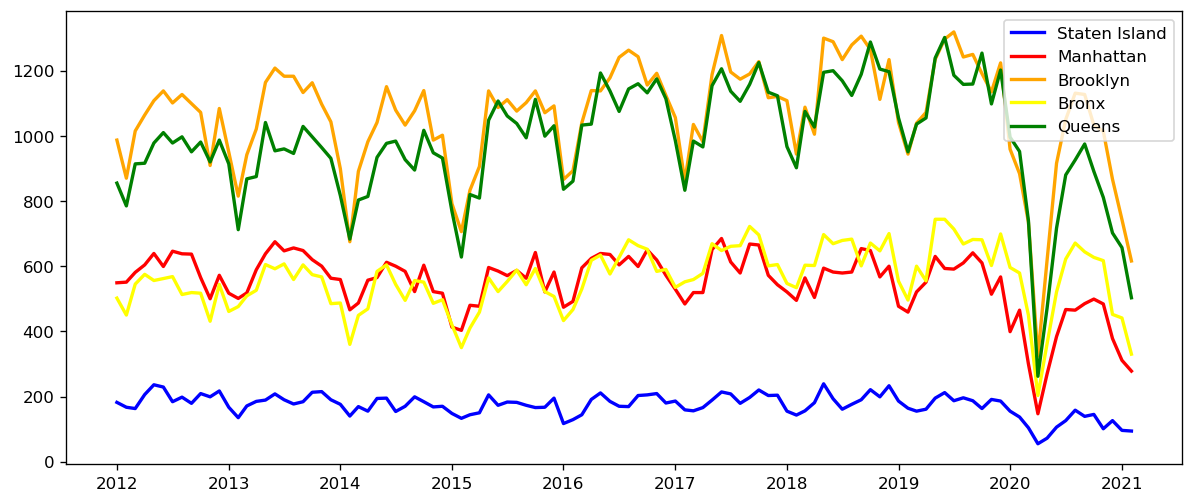

In [146]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(pd.to_datetime(dfStat.Date),'Injury_or_fatal_collisions', data=dfStat, marker='', color='blue', linewidth=2, label="Staten Island")
plt.plot(pd.to_datetime(dfMan.Date),'Injury_or_fatal_collisions', data=dfMan, marker='', color='red', linewidth=2, label="Manhattan")
plt.plot(pd.to_datetime(dfBk.Date),'Injury_or_fatal_collisions', data=dfBk, marker='', color='orange', linewidth=2, label="Brooklyn")
plt.plot(pd.to_datetime(dfBronx.Date),'Injury_or_fatal_collisions', data=dfBronx, marker='', color='yellow', linewidth=2, label="Bronx")
plt.plot(pd.to_datetime(dfQueens.Date),'Injury_or_fatal_collisions', data=dfQueens, marker='', color='green', linewidth=2, label="Queens")
plt.legend()
plt.show()

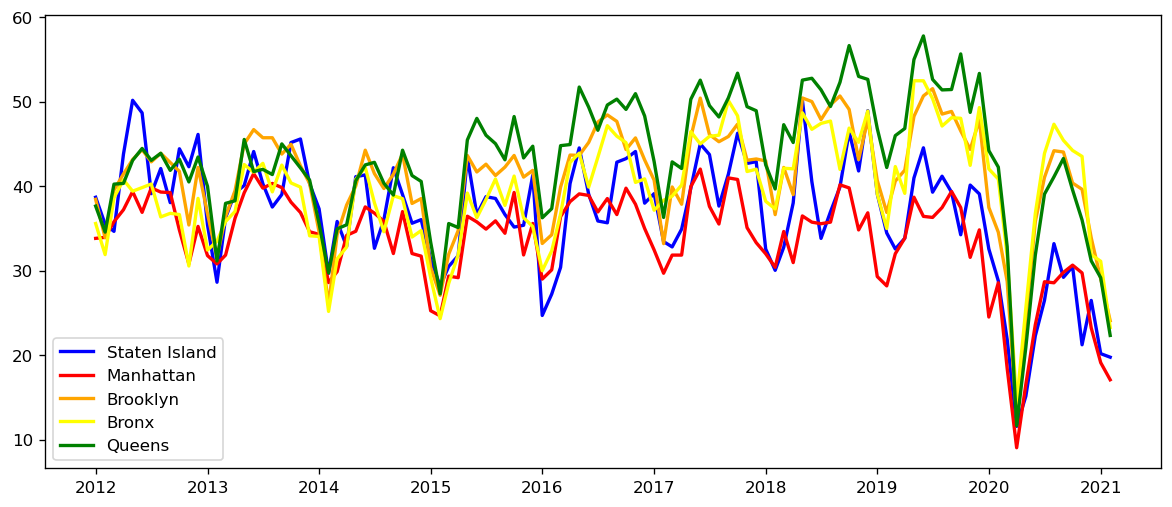

In [157]:
fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(pd.to_datetime(dfStat.Date),'Inj_or_fatal_coll_Population', data=dfStat, marker='', color='blue', linewidth=2, label="Staten Island")
plt.plot(pd.to_datetime(dfMan.Date),'Inj_or_fatal_coll_Population', data=dfMan, marker='', color='red', linewidth=2, label="Manhattan")
plt.plot(pd.to_datetime(dfBk.Date),'Inj_or_fatal_coll_Population', data=dfBk, marker='', color='orange', linewidth=2, label="Brooklyn")
plt.plot(pd.to_datetime(dfBronx.Date),'Inj_or_fatal_coll_Population', data=dfBronx, marker='', color='yellow', linewidth=2, label="Bronx")
plt.plot(pd.to_datetime(dfQueens.Date),'Inj_or_fatal_coll_Population', data=dfQueens, marker='', color='green', linewidth=2, label="Queens")
plt.legend()
plt.show()

In [9]:
dfs=[dfMan[:96],dfBronx[:96],dfBk[:96],dfQueens[:96],dfStat[:96]]
for df in dfs:
    f, PSD = scipy.signal.periodogram(df['Injury_or_fatal_collisions'])
    PSD = PSD[f>0.01]
    f = f[f>0.01]
    print('Strongest period of {0} = {1}'.format(df['Borough'][1],1/f[np.argmax(PSD)]))

Strongest period of MANHATTAN = 12.0
Strongest period of BRONX = 96.0
Strongest period of BROOKLYN = 12.0
Strongest period of QUEENS = 96.0
Strongest period of STATEN ISLAND = 6.0


In [161]:
dfs=[dfMan[:96],dfBronx[:96],dfBk[:96],dfQueens[:96],dfStat[:96]]
for df in dfs:
    f, PSD = scipy.signal.periodogram(df['Inj_or_fatal_coll_Population'])
    PSD = PSD[f>0.01]
    f = f[f>0.01]
    print('Strongest period of {0} = {1}'.format(df['Borough'][1],1/f[np.argmax(PSD)]))

Strongest period of MANHATTAN = 12.0
Strongest period of BRONX = 96.0
Strongest period of BROOKLYN = 12.0
Strongest period of QUEENS = 96.0
Strongest period of STATEN ISLAND = 6.0


In [137]:
for df in dfs:
    f, PSD = scipy.signal.periodogram(df['Fatalities'])
    PSD = PSD[f>0.01]
    f = f[f>0.01]
    print('Strongest period of {0} = {1}'.format(df['Borough'][1],1/f[np.argmax(PSD)]))

Strongest period of MANHATTAN = 4.173913043478261
Strongest period of BRONX = 19.200000000000003
Strongest period of BROOKLYN = 96.0
Strongest period of QUEENS = 96.0
Strongest period of STATEN ISLAND = 16.0


In [10]:
for df in dfs:
    print(df['Borough'][1],df['Injury_or_fatal_collisions'][84:96].mean())

MANHATTAN 563.6666666666666
BRONX 644.9166666666666
BROOKLYN 1165.75
QUEENS 1141.25
STATEN ISLAND 181.91666666666666


In [12]:
df_monthly=dfMan[['Date','Injury_or_fatal_collisions']].copy()
df_monthly['Injury_or_fatal_collisions']=dfMan['Injury_or_fatal_collisions']+dfBk['Injury_or_fatal_collisions']+dfBronx['Injury_or_fatal_collisions']+dfQueens['Injury_or_fatal_collisions']+dfStat['Injury_or_fatal_collisions']
df_monthly.head(2)

,Date,Injury_or_fatal_collisions
0,1-2012,3075
1,2-2012,2823


In [13]:
print(df_monthly['Injury_or_fatal_collisions'][84:96].mean())

3697.5


_________________________________________________________________________

## Bronx Model

In [99]:
f, PSD = scipy.signal.periodogram(dfBronx['Injury_or_fatal_collisions'][:96])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 96.0


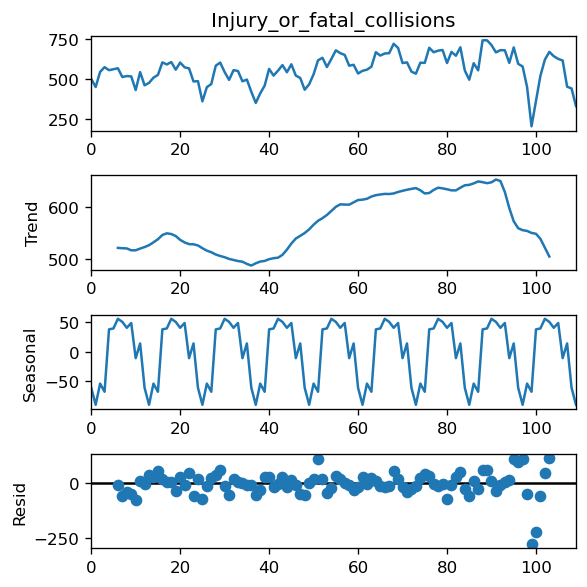

In [100]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfBronx['Injury_or_fatal_collisions'],model='additive',freq=12)
res.plot()
plt.show()

In [101]:
result = adfuller(dfBronx['Injury_or_fatal_collisions'])
print('p-value: %f' % result[1])
result = adfuller(dfBronx['Injury_or_fatal_collisions'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.839714
p-value: 0.001117


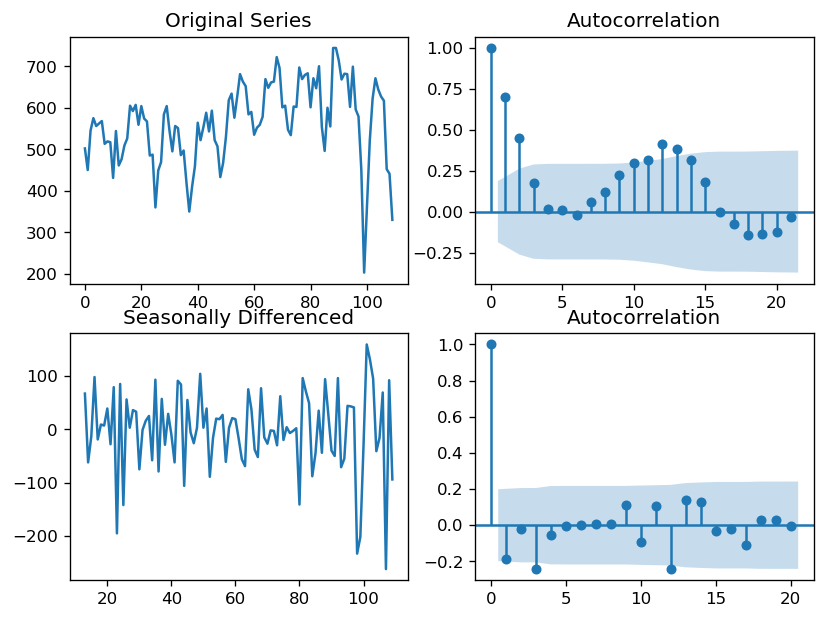

In [102]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfBronx['Injury_or_fatal_collisions']); axes[0, 0].set_title('Original Series')
plot_acf(dfBronx['Injury_or_fatal_collisions'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfBronx['Injury_or_fatal_collisions'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfBronx['Injury_or_fatal_collisions'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [103]:
model = pm.auto_arima(dfBronx['Injury_or_fatal_collisions'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1102.540, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1116.867, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1107.972, Time=0.24 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1101.185, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1114.501, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1103.183, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1103.182, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1107.663, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1100.540, Time=0.09 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1102.540, Time=0.31 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1107.952, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1101.425, Time=0.20 sec
 ARIMA(1,1,1)(0,1,1)[12]     

In [104]:
trainBronx=dfBronx[['Date','Injury_or_fatal_collisions']][:84]
validBronx=dfBronx[['Date','Injury_or_fatal_collisions']][84:96]
testBronx=dfBronx[['Date','Injury_or_fatal_collisions']][96:]
modelBronx = SARIMAX(trainBronx['Injury_or_fatal_collisions'],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBronx = modelBronx.fit()
resultsBronx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:         Injury_or_fatal_collisions   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -370.943
Date:                            Tue, 27 Apr 2021   AIC                            749.885
Time:                                    16:19:41   BIC                            758.936
Sample:                                         0   HQIC                           753.484
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2272      0.239      0.951      0.342      -0.241       0.695
ma.L1         -0.7199      0.176     -4.094      0.000      -1.065      -0.375
ma.S.L12      -0.9986     44.527     -0.022      0.982     -88.271      86.273
sigma2      1452.2270   6.46e+04      0.022      0.982   -1.25e+05    1.28e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.90   Prob(JB):                         0.20
Heteroskedasticity (H):               0.58   Skew:                            -0.32
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

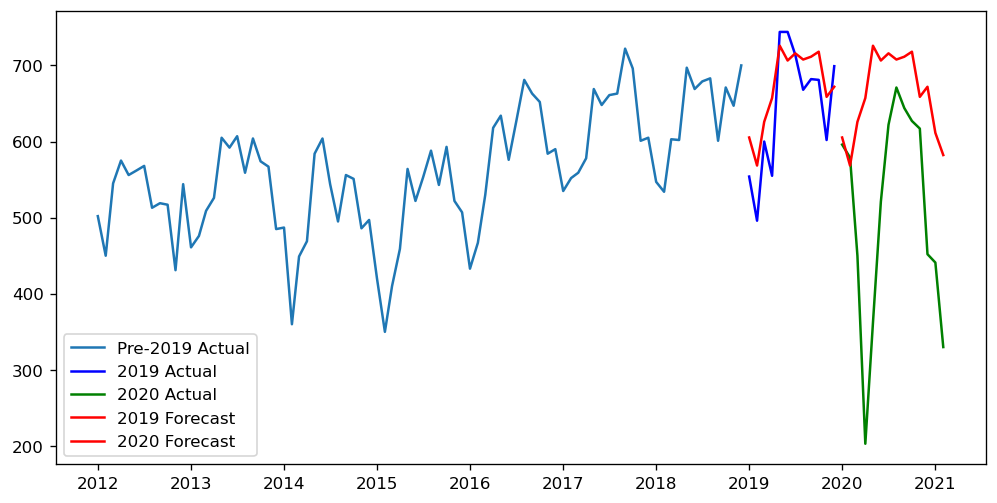

In [105]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainBronx.Date), trainBronx['Injury_or_fatal_collisions'],label='Pre-2019 Actual')
plt.plot(pd.to_datetime(validBronx.Date), validBronx['Injury_or_fatal_collisions'],color='blue',label='2019 Actual')
plt.plot(pd.to_datetime(testBronx.Date), testBronx['Injury_or_fatal_collisions'],color='green',label='2020 Actual')
plt.plot(pd.to_datetime(validBronx.Date), resultsBronx.forecast(steps=len(validBronx), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testBronx.Date), resultsBronx.forecast(steps=len(testBronx), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [106]:
r2_score(validBronx['Injury_or_fatal_collisions'], resultsBronx.forecast(steps=len(validBronx), alpha=0.05))

0.6093146325056696

In [107]:
r2_score(testBronx['Injury_or_fatal_collisions'], resultsBronx.forecast(steps=len(testBronx), alpha=0.05))

-1.2431721392097144

In [108]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [109]:
mean_absolute_percentage_error(validBronx['Injury_or_fatal_collisions'],resultsBronx.forecast(steps=len(validBronx)))

6.943541549473835

In [110]:
mean_absolute_percentage_error(testBronx['Injury_or_fatal_collisions'],resultsBronx.forecast(steps=len(testBronx)))

44.166240000668125

## Bronx Model MAPE 2019: 6.94%, 2020: 44.2%

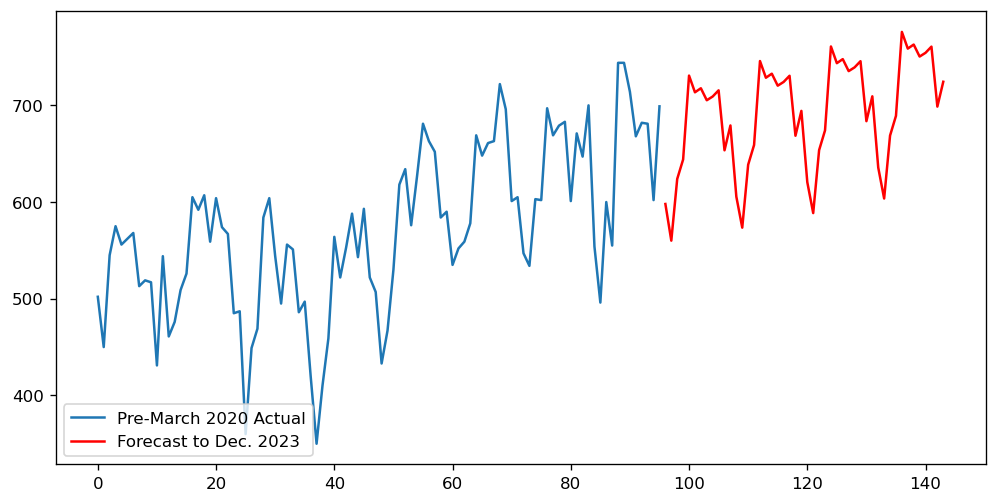

In [132]:
modelBronx2 = SARIMAX(dfBronx['Injury_or_fatal_collisions'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBronx2 = modelBronx2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfBronx.index[:96], dfBronx['Injury_or_fatal_collisions'][:96],label='Pre-March 2020 Actual')
plt.plot(x[96:], resultsBronx2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [133]:
res=resultsBronx2.forecast(24)
res[12:].mean()

685.1614120814666

In [134]:
res=resultsBronx2.forecast(36)
res[24:].mean()

700.2270931245021

In [135]:
res=resultsBronx2.forecast(48)
res[36:].mean()

715.2927741754784

In [136]:
res=resultsBronx2.forecast(60)
res[48:].mean()

730.3584552264548

## Projected Avgs./Month/Year: 685, 700, 715, 730

___________________________________________________________________________________________________________________________

## Staten Island Model

Period of 6 months (as opposed to 12 in other boroughs)

In [16]:
result = adfuller(dfStat['Injury_or_fatal_collisions'])
print('p-value: %f' % result[1])
result = adfuller(dfStat['Injury_or_fatal_collisions'].diff().diff(6).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.989831
p-value: 0.000000


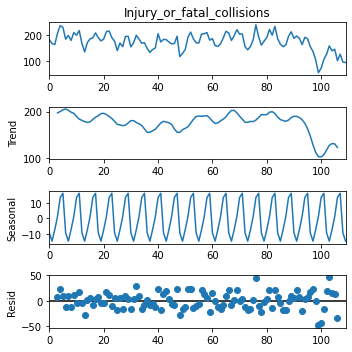

In [17]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfStat['Injury_or_fatal_collisions'],model='additive',freq=6)
res.plot()
plt.show()

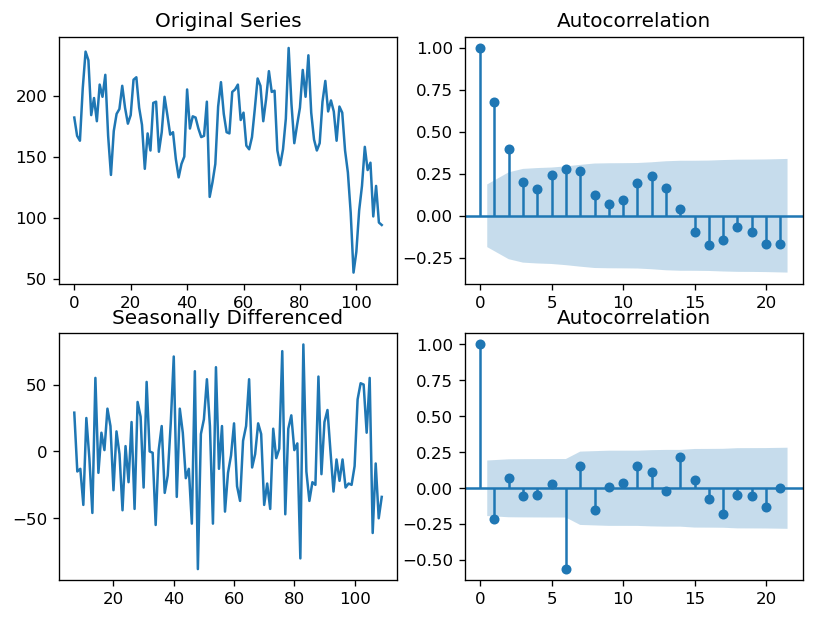

In [18]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfStat['Injury_or_fatal_collisions']); axes[0, 0].set_title('Original Series')
plot_acf(dfStat['Injury_or_fatal_collisions'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfStat['Injury_or_fatal_collisions'].diff().diff(6)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfStat['Injury_or_fatal_collisions'].diff().diff(6).dropna(), ax=axes[1, 1])
plt.show()

In [19]:
model = pm.auto_arima(dfStat['Injury_or_fatal_collisions'], d=1, D=1,
                      m=6, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=12, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[6]             : AIC=966.823, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=1026.840, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=980.185, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=964.592, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[6]             : AIC=1024.427, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[6]             : AIC=964.996, Time=0.24 sec
 ARIMA(0,1,1)(0,1,2)[6]             : AIC=965.278, Time=0.30 sec
 ARIMA(0,1,1)(1,1,0)[6]             : AIC=975.511, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[6]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,1,1)[6]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,2)(0,1,1)[6]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,1)[6]             : AIC=965.068, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[6]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[6] intercept   : AIC=964.592, Time=0.09 sec


In [21]:
trainSt=dfStat[['Date','Injury_or_fatal_collisions']][:84]
validSt=dfStat[['Date','Injury_or_fatal_collisions']][84:96]
testSt=dfStat[['Date','Injury_or_fatal_collisions']][96:]
modelSt = SARIMAX(trainSt['Injury_or_fatal_collisions'],order=(0,1,1),seasonal_order=(0,1,1,6))
resultsSt = modelSt.fit()
resultsSt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:        Injury_or_fatal_collisions   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 6)   Log Likelihood                -348.369
Date:                           Tue, 27 Apr 2021   AIC                            702.737
Time:                                   15:56:12   BIC                            709.769
Sample:                                        0   HQIC                           705.550
                                            - 84                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5231      0.132     -3.974      0.000      -0.781      -0.265
ma.S.L6       -0.9999    221.331     -0.005      0.996    -434.800     432.801
sigma2       404.0984   8.94e+04      0.005      0.996   -1.75e+05    1.76e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 1.60
Prob(Q):                              0.64   Prob(JB):                         0.45
Heteroskedasticity (H):               1.27   Skew:                             0.13
Prob(H) (two-sided):                  0.55   Kurtosis:                         2.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

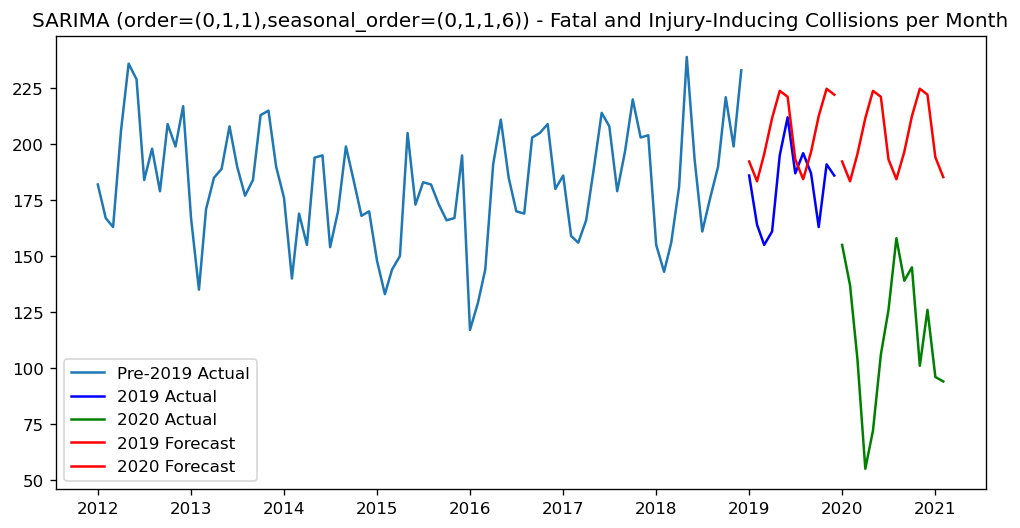

In [23]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainSt.Date), trainSt['Injury_or_fatal_collisions'],label='Pre-2019 Actual')
plt.plot(pd.to_datetime(validSt.Date), validSt['Injury_or_fatal_collisions'],color='blue',label='2019 Actual')
plt.plot(pd.to_datetime(testSt.Date), testSt['Injury_or_fatal_collisions'],color='green',label='2020 Actual')
plt.plot(pd.to_datetime(validSt.Date), resultsSt.forecast(steps=len(validSt), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testSt.Date), resultsSt.forecast(steps=len(testSt), alpha=0.05), label='2020 Forecast', color='red')
plt.title('SARIMA (order=(0,1,1),seasonal_order=(0,1,1,6)) - Fatal and Injury-Inducing Collisions per Month')
plt.legend(loc='lower left')

In [24]:
r2_score(validSt['Injury_or_fatal_collisions'], resultsSt.forecast(steps=len(validSt), alpha=0.05))

-2.2647109139085666

In [25]:
r2_score(testSt['Injury_or_fatal_collisions'], resultsSt.forecast(steps=len(testSt), alpha=0.05))

-9.442410257072543

In [27]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
mean_absolute_percentage_error(validSt['Injury_or_fatal_collisions'],resultsSt.forecast(steps=len(validSt)))

14.492887518264071

In [29]:
mean_absolute_percentage_error(testSt['Injury_or_fatal_collisions'],resultsSt.forecast(steps=len(testSt)))

93.33378591244518

## Staten Island MAPE 2019: 14.5%, 2020: 93.3%

In [31]:
x = np.arange(144)

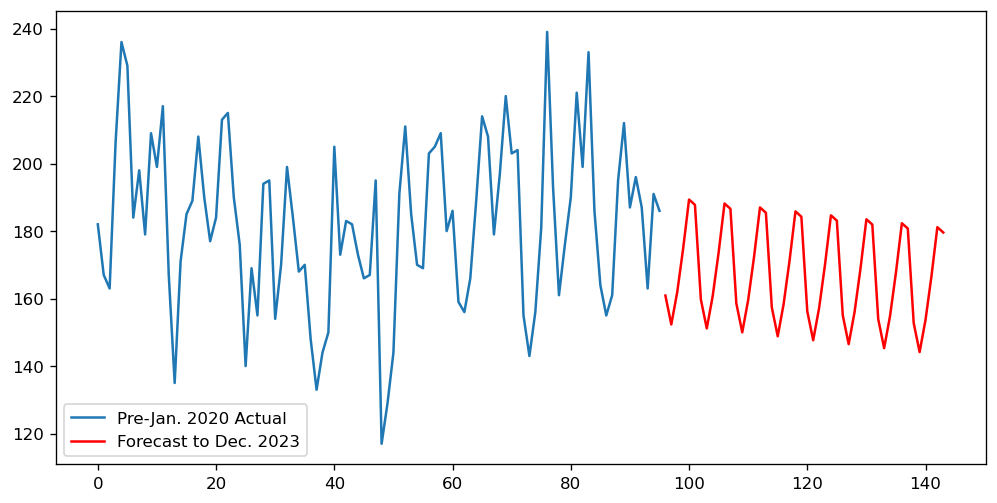

In [32]:
modelSt2 = SARIMAX(dfStat['Injury_or_fatal_collisions'][:96],order=(0,1,1),seasonal_order=(0,1,1,6))
resultsSt2 = modelSt2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfStat.index[:96], dfStat['Injury_or_fatal_collisions'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsSt2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [36]:
res=resultsSt2.forecast(24)
res[12:].mean()

168.24770134428837

In [35]:
res=resultsSt2.forecast(36)
res[24:].mean()

165.9109334315249

In [34]:
res=resultsSt2.forecast(48)
res[36:].mean()

163.5741655187615

In [33]:
res=resultsSt2.forecast(60)
res[48:].mean()

161.23739760599804

## Projected Avgs./Month/Year: 168,166,164,161

_________________________________________________________________________________________________________________

## Queens Model

In [116]:
f, PSD = scipy.signal.periodogram(dfQueens['Injury_or_fatal_collisions'][:96])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 96.0


In [117]:
result = adfuller(dfQueens['Injury_or_fatal_collisions'])
print('p-value: %f' % result[1])
result = adfuller(dfQueens['Injury_or_fatal_collisions'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.787500
p-value: 0.000000


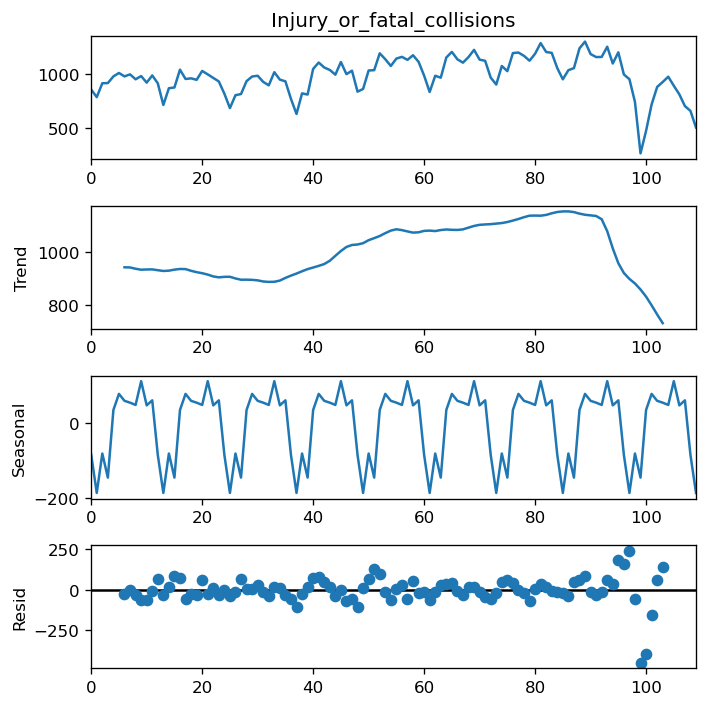

In [118]:
matplotlib.rcParams['figure.figsize'] = [6,6]
res = sm.tsa.seasonal_decompose(dfQueens['Injury_or_fatal_collisions'],model='additive',freq=12)
res.plot()
plt.show()

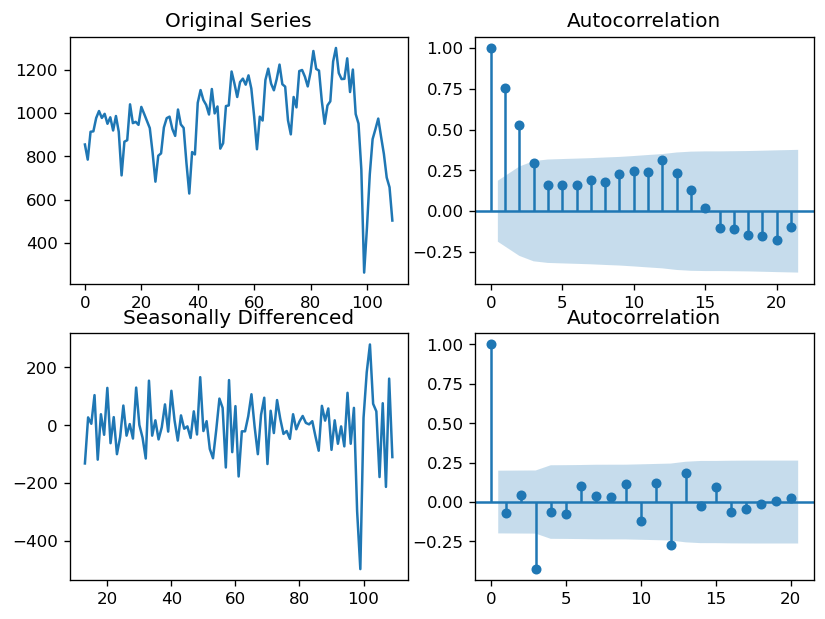

In [119]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfQueens['Injury_or_fatal_collisions']); axes[0, 0].set_title('Original Series')
plot_acf(dfQueens['Injury_or_fatal_collisions'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfQueens['Injury_or_fatal_collisions'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfQueens['Injury_or_fatal_collisions'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [120]:
model = pm.auto_arima(dfQueens['Injury_or_fatal_collisions'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1162.173, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1177.901, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1165.943, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1162.459, Time=0.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1161.205, Time=0.12 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1162.076, Time=0.27 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1164.158, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=1164.148, Time=0.74 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1162.516, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1164.459, Time=0.31 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1161.205, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 2.560 seconds


In [121]:
trainQn=dfQueens[['Date','Injury_or_fatal_collisions']][:84]
validQn=dfQueens[['Date','Injury_or_fatal_collisions']][84:96]
testQn=dfQueens[['Date','Injury_or_fatal_collisions']][96:]
modelQn = SARIMAX(trainQn['Injury_or_fatal_collisions'],order=(0,1,0),seasonal_order=(0,1,1,12))
resultsQn = modelQn.fit()
resultsQn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:           Injury_or_fatal_collisions   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -389.261
Date:                              Tue, 27 Apr 2021   AIC                            782.522
Time:                                      16:24:05   BIC                            787.047
Sample:                                           0   HQIC                           784.321
                                               - 84                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9900      7.417     -0.133      0.894     -15.526      13.546
sigma2      2460.8679   1.81e+04      0.136      0.892    -3.3e+04    3.79e+04
===================================================================================
Ljung-Box (L1) (Q):                   6.45   Jarque-Bera (JB):                 3.04
Prob(Q):                              0.01   Prob(JB):                         0.22
Heteroskedasticity (H):               0.41   Skew:                             0.51
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

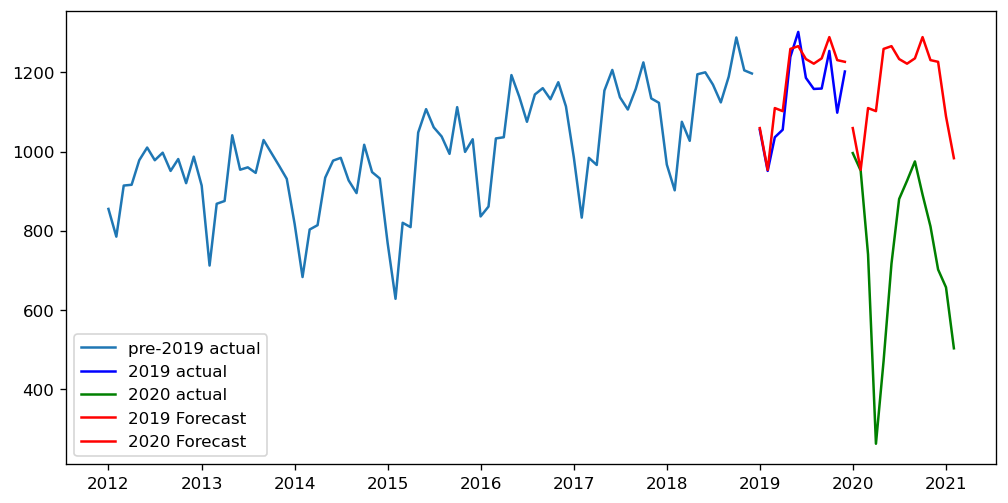

In [122]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainQn.Date), trainQn['Injury_or_fatal_collisions'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validQn.Date), validQn['Injury_or_fatal_collisions'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testQn.Date), testQn['Injury_or_fatal_collisions'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validQn.Date), resultsQn.forecast(steps=len(validQn), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testQn.Date), resultsQn.forecast(steps=len(testQn), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [123]:
print('2019 R2 Score:',r2_score(validQn['Injury_or_fatal_collisions'], resultsQn.forecast(steps=len(validQn), alpha=0.05)))
print('2020 R2 Score:',r2_score(testQn['Injury_or_fatal_collisions'], resultsQn.forecast(steps=len(testQn), alpha=0.05)))

2019 R2 Score: 0.6541856925803694
2020 R2 Score: -4.020829893471999


In [124]:
mean_absolute_percentage_error(validQn['Injury_or_fatal_collisions'],resultsQn.forecast(steps=len(validQn)))

4.134999090982105

In [125]:
mean_absolute_percentage_error(testQn['Injury_or_fatal_collisions'],resultsQn.forecast(steps=len(testQn)))

75.14679419323865

## Queens Model MAPE 2019: 4.13%, 2020: 75.1%

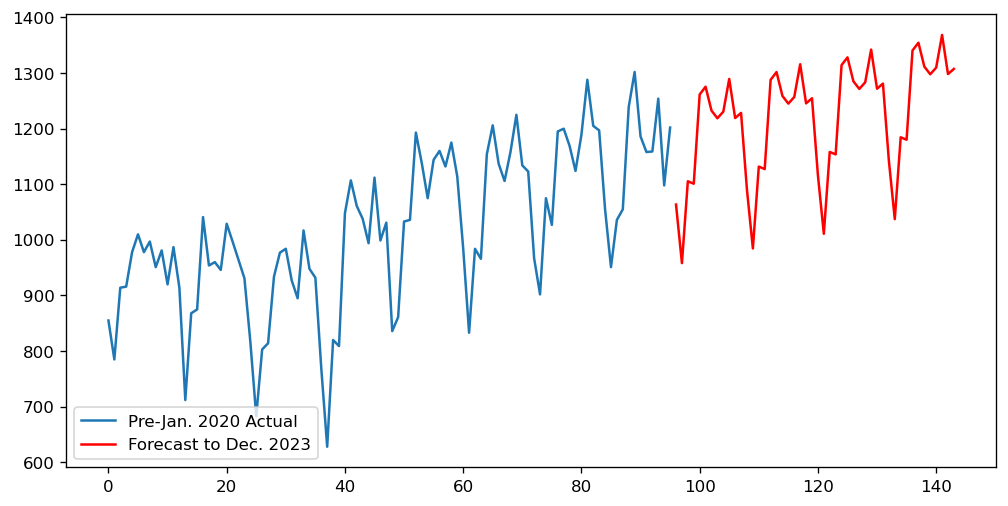

In [127]:
modelQn2 = SARIMAX(dfQueens['Injury_or_fatal_collisions'][:96],order=(0,1,0),seasonal_order=(0,1,1,12))
resultsQn2 = modelQn2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfMan.index[:96], dfQueens['Injury_or_fatal_collisions'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsQn2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [128]:
res=resultsQn2.forecast(24)
res[12:].mean()

1208.3796191622769

In [129]:
res=resultsQn2.forecast(36)
res[24:].mean()

1234.7573555083081

In [130]:
res=resultsQn2.forecast(48)
res[36:].mean()

1261.1350918543394

In [131]:
res=resultsQn2.forecast(60)
res[48:].mean()

1287.5128282003707

## Predicted Avgs./Month/Year: 1208, 1235, 1261, 1288

 _______________________________________________________________________________________________________________________

## Manhattan Model

In [37]:
f, PSD = scipy.signal.periodogram(dfMan['Injury_or_fatal_collisions'][:96])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.0


In [38]:
result = adfuller(dfMan['Injury_or_fatal_collisions'])
print('p-value: %f' % result[1])
result = adfuller(dfMan['Injury_or_fatal_collisions'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.993769
p-value: 0.000864


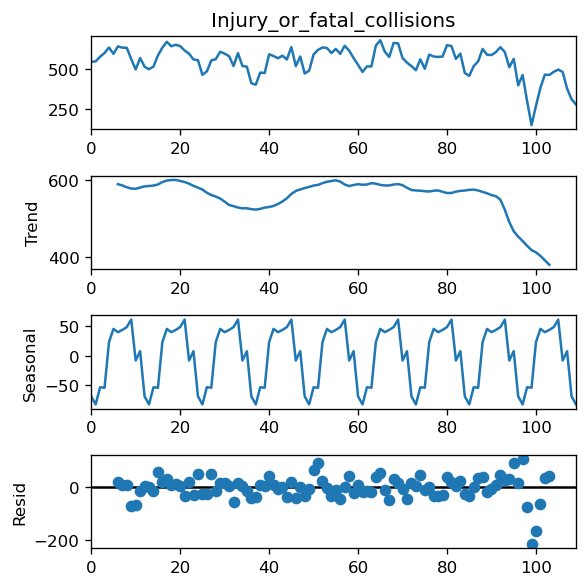

In [39]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfMan['Injury_or_fatal_collisions'],model='additive',freq=12)
res.plot()
plt.show()

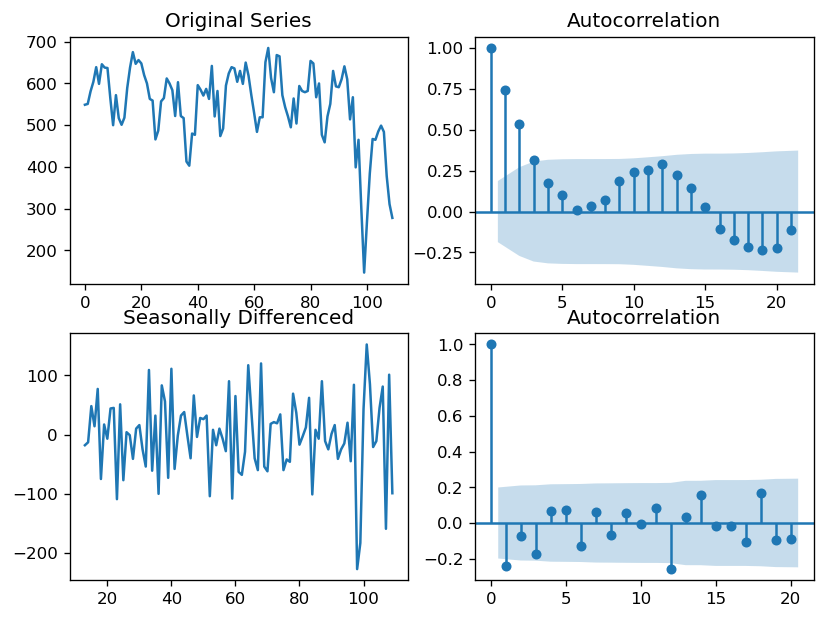

In [40]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfMan['Injury_or_fatal_collisions']); axes[0, 0].set_title('Original Series')
plot_acf(dfMan['Injury_or_fatal_collisions'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfMan['Injury_or_fatal_collisions'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfMan['Injury_or_fatal_collisions'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [41]:
model = pm.auto_arima(dfMan['Injury_or_fatal_collisions'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1074.312, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1092.269, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1077.240, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1068.146, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1085.234, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1070.067, Time=0.23 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1070.051, Time=0.42 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1073.901, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1072.431, Time=0.11 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1063.920, Time=0.34 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1081.509, Time=0.09 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1065.906, Time=0.31 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1065.903, Time=0.63 sec
 ARIMA(1,1,1)(1,1,0)[12]

In [42]:
trainMan=dfMan[['Date','Injury_or_fatal_collisions']][:84]
validMan=dfMan[['Date','Injury_or_fatal_collisions']][84:96]
testMan=dfMan[['Date','Injury_or_fatal_collisions']][96:]
modelMan = SARIMAX(trainMan['Injury_or_fatal_collisions'],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsMan = modelMan.fit()
resultsMan.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:         Injury_or_fatal_collisions   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -367.674
Date:                            Tue, 27 Apr 2021   AIC                            743.348
Time:                                    16:04:02   BIC                            752.399
Sample:                                         0   HQIC                           746.947
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0977      0.259      0.378      0.706      -0.409       0.605
ma.L1         -0.6739      0.193     -3.484      0.000      -1.053      -0.295
ma.S.L12      -0.7184      0.192     -3.747      0.000      -1.094      -0.343
sigma2      1622.6682    319.157      5.084      0.000     997.132    2248.204
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.41
Prob(Q):                              0.96   Prob(JB):                         0.49
Heteroskedasticity (H):               0.92   Skew:                             0.21
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

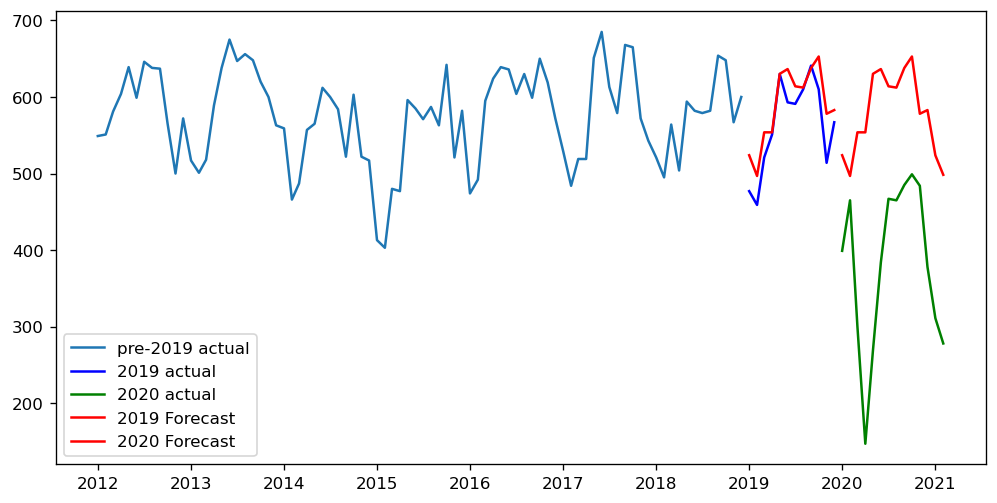

In [43]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainMan.Date), trainMan['Injury_or_fatal_collisions'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validMan.Date), validMan['Injury_or_fatal_collisions'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testMan.Date), testMan['Injury_or_fatal_collisions'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validMan.Date), resultsMan.forecast(steps=len(validMan), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testMan.Date), resultsMan.forecast(steps=len(testMan), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [45]:
r2_score(validMan['Injury_or_fatal_collisions'], resultsMan.forecast(steps=len(validMan), alpha=0.05))

0.6593437760247656

In [46]:
r2_score(testMan['Injury_or_fatal_collisions'], resultsMan.forecast(steps=len(testMan), alpha=0.05))

-3.6107320270920873

In [47]:
mean_absolute_percentage_error(validMan['Injury_or_fatal_collisions'],resultsMan.forecast(steps=len(validMan)))

4.943760469816556

In [48]:
mean_absolute_percentage_error(testMan['Injury_or_fatal_collisions'],resultsMan.forecast(steps=len(testMan)))

67.59805012375743

## Manhattan Model MAPE 2019: 4.94%, 2020: 67.6%

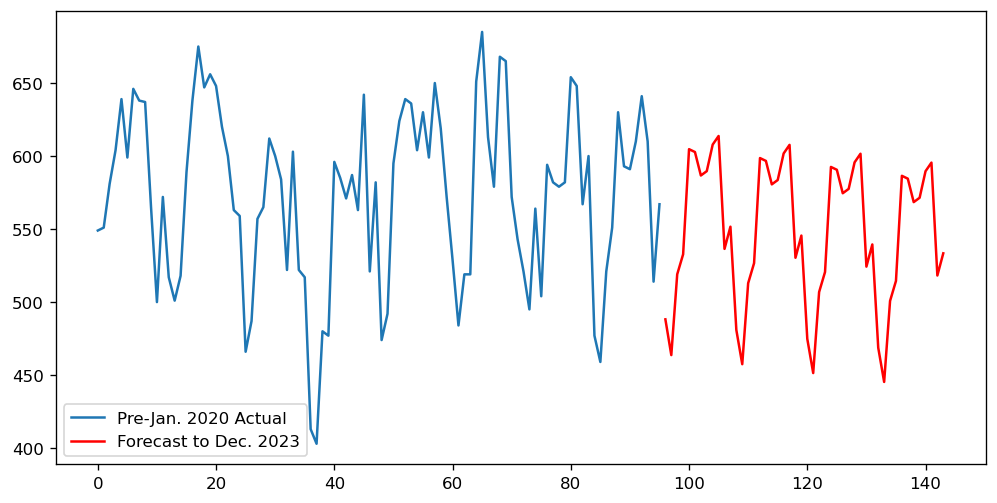

In [49]:
modelMan2 = SARIMAX(dfMan['Injury_or_fatal_collisions'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsMan2 = modelMan2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfMan.index[:96], dfMan['Injury_or_fatal_collisions'][:96],label='Pre-Jan. 2020 Actual')
plt.plot(x[96:], resultsMan2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [50]:
res=resultsMan2.forecast(24)
res[12:].mean()

551.9032866186076

In [51]:
res=resultsMan2.forecast(36)
res[24:].mean()

545.8266833569115

In [52]:
res=resultsMan2.forecast(48)
res[36:].mean()

539.750080095218

In [53]:
res=resultsMan2.forecast(60)
res[48:].mean()

533.6734768335244

## Projected Avgs./Month/Year: 552, 546, 540, 534

 _______________________________________________________________________________________________________________________

## Brooklyn Model

In [54]:
f, PSD = scipy.signal.periodogram(dfBk['Injury_or_fatal_collisions'])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.222222222222221


In [55]:
result = adfuller(dfBk['Injury_or_fatal_collisions'])
print('p-value: %f' % result[1])
result = adfuller(dfBk['Injury_or_fatal_collisions'].diff().diff(12).dropna().values)
print('p-value: %f' % result[1])

p-value: 0.931032
p-value: 0.002783


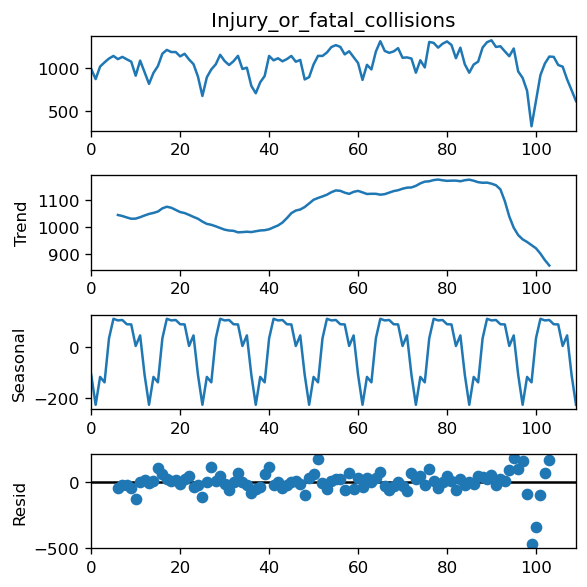

In [56]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(dfBk['Injury_or_fatal_collisions'],model='additive',freq=12)
res.plot()
plt.show()

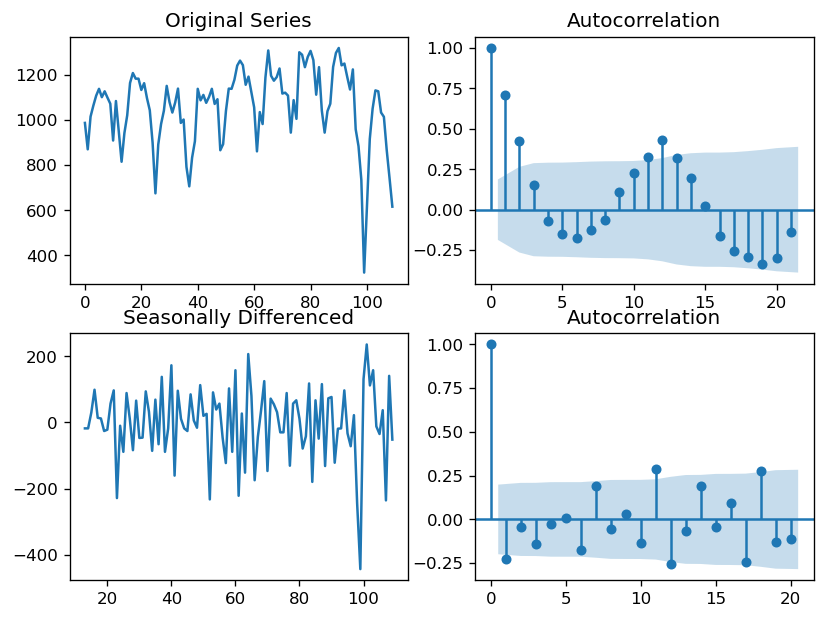

In [57]:
plt.rcParams.update({'figure.figsize':(8,6), 'figure.dpi':120})
fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(dfBk['Injury_or_fatal_collisions']); axes[0, 0].set_title('Original Series')
plot_acf(dfBk['Injury_or_fatal_collisions'].dropna(), ax=axes[0, 1])

axes[1, 0].plot(dfBk['Injury_or_fatal_collisions'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(dfBk['Injury_or_fatal_collisions'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [59]:
model = pm.auto_arima(dfBk['Injury_or_fatal_collisions'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1176.959, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1193.238, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1183.294, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1175.154, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1188.499, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1177.108, Time=0.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1177.040, Time=0.50 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1182.260, Time=0.13 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1175.014, Time=0.17 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1176.859, Time=0.33 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1185.526, Time=0.09 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.00 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1175.570, Time=0.22 sec
 ARIMA(1,1,1)(0,1,1)[12]     

In [60]:
trainBk=dfBk[['Date','Injury_or_fatal_collisions']][:84]
validBk=dfBk[['Date','Injury_or_fatal_collisions']][84:96]
testBk=dfBk[['Date','Injury_or_fatal_collisions']][96:]

In [61]:
modelBk = SARIMAX(trainBk['Injury_or_fatal_collisions'],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBk = modelBk.fit()
resultsBk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:         Injury_or_fatal_collisions   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -400.927
Date:                            Tue, 27 Apr 2021   AIC                            809.854
Time:                                    16:09:18   BIC                            818.905
Sample:                                         0   HQIC                           813.453
                                             - 84                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0300      0.195      0.154      0.878      -0.353       0.412
ma.L1         -0.6653      0.152     -4.391      0.000      -0.962      -0.368
ma.S.L12      -0.9991     63.007     -0.016      0.987    -124.491     122.492
sigma2      3374.7224   2.12e+05      0.016      0.987   -4.13e+05    4.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.86   Prob(JB):                         0.60
Heteroskedasticity (H):               1.16   Skew:                            -0.26
Prob(H) (two-sided):                  0.72   Kurtosis:                         2.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

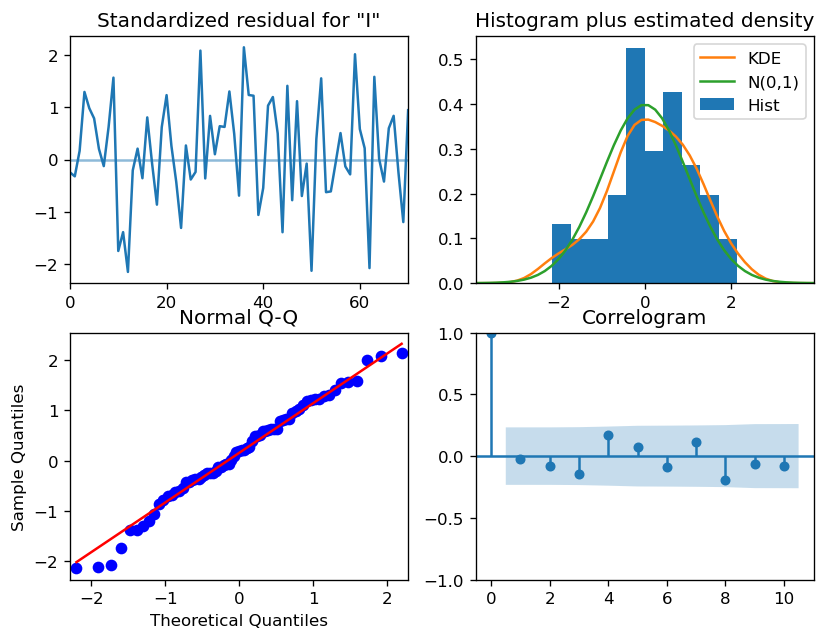

In [62]:
resultsBk.plot_diagnostics()
plt.show()

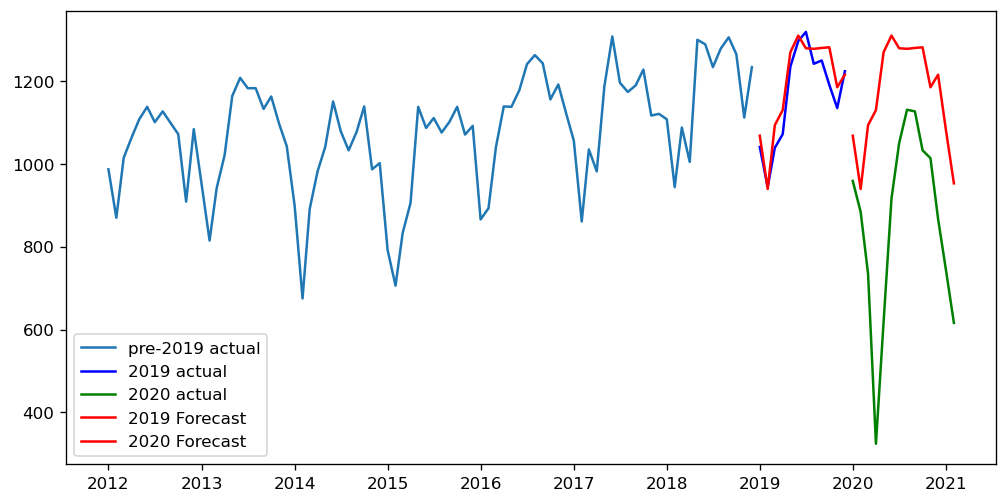

In [63]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(trainBk.Date), trainBk['Injury_or_fatal_collisions'],label='pre-2019 actual')
plt.plot(pd.to_datetime(validBk.Date), validBk['Injury_or_fatal_collisions'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(testBk.Date), testBk['Injury_or_fatal_collisions'],color='green',label='2020 actual')
plt.plot(pd.to_datetime(validBk.Date), resultsBk.forecast(steps=len(validBk), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(testBk.Date), resultsBk.forecast(steps=len(testBk), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [64]:
r2_score(validBk['Injury_or_fatal_collisions'], resultsBk.forecast(steps=len(validBk), alpha=0.05))

0.8486593896108646

In [65]:
r2_score(testBk['Injury_or_fatal_collisions'], resultsBk.forecast(steps=len(testBk), alpha=0.05))

-1.801077496010424

In [66]:
mean_absolute_percentage_error(validBk['Injury_or_fatal_collisions'],resultsBk.forecast(steps=len(validBk)))

3.22273483520893

In [67]:
mean_absolute_percentage_error(testBk['Injury_or_fatal_collisions'],resultsBk.forecast(steps=len(testBk)))

49.54844277791482

## Brooklyn Model MAPE 2019: 3.22%, 2020: 49.6%

In [68]:
x = np.arange(144)

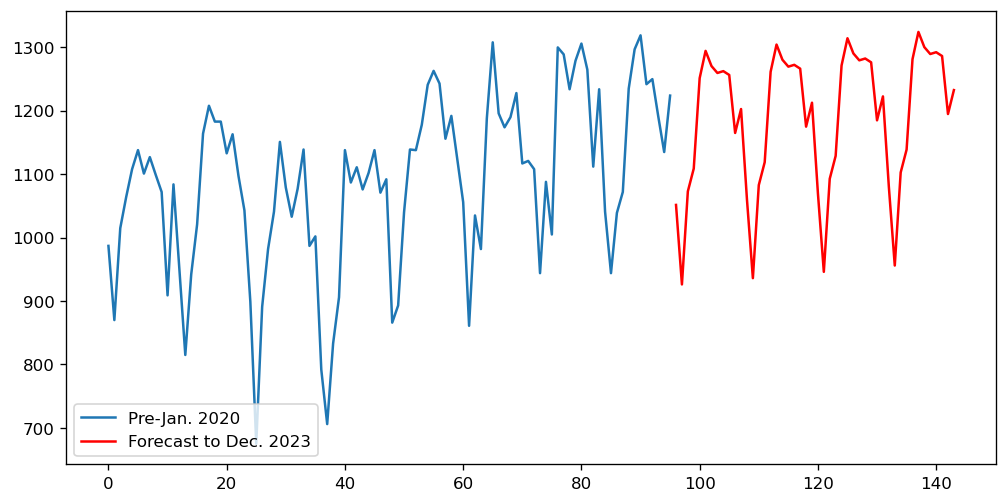

In [69]:
modelBk2 = SARIMAX(dfBk['Injury_or_fatal_collisions'][:96],order=(1,1,1),seasonal_order=(0,1,1,12))
resultsBk2 = modelBk2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(dfBk.index[:96], dfBk['Injury_or_fatal_collisions'][:96],label='Pre-Jan. 2020')
plt.plot(x[96:], resultsBk2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [70]:
res=resultsBk2.forecast(24)
res[12:].mean()

1186.7575911341585

In [71]:
res=resultsBk2.forecast(36)
res[24:].mean()

1196.7131239542643

In [72]:
res=resultsBk2.forecast(48)
res[36:].mean()

1206.6686567743702

In [73]:
res=resultsBk2.forecast(60)
res[48:].mean()

1216.624189594476

## Projected Avgs./Month/Year: 1187, 1198, 1207, 1217

 _______________________________________________________________________________________________________________________

## Citywide Model

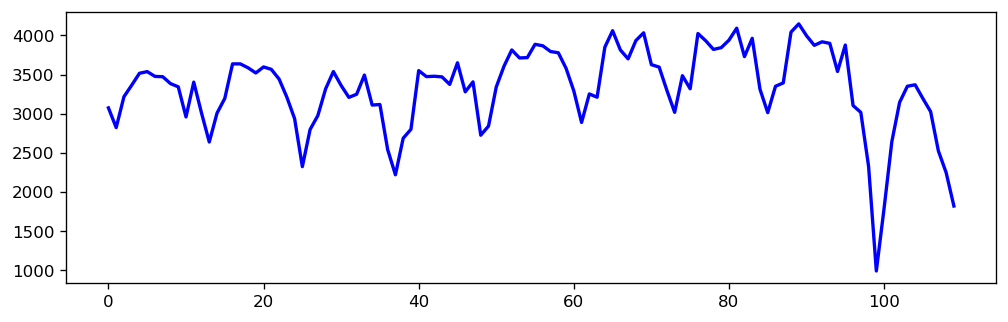

In [74]:
fig, ax = plt.subplots(figsize=(10, 3))
plt.plot(df_monthly.index,'Injury_or_fatal_collisions', data=df_monthly, marker='', color='blue', linewidth=2)
plt.show()

In [75]:
f, PSD = scipy.signal.periodogram(df_monthly['Injury_or_fatal_collisions'])
PSD = PSD[f>0.01]
f = f[f>0.01]
print('Strongest period = {}'.format(1/f[np.argmax(PSD)]))

Strongest period = 12.222222222222221


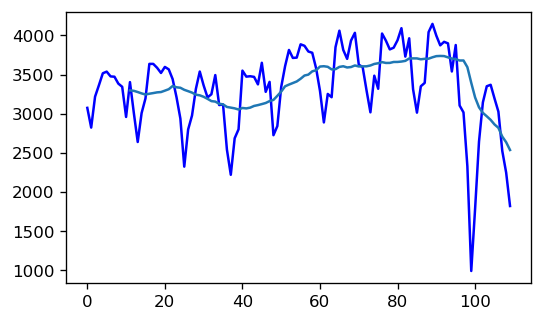

In [76]:
df_monthly['Injury_or_fatal_collisions'].plot(color='blue', figsize=(5, 3))
plt.plot(df_monthly['Injury_or_fatal_collisions'].rolling(window = 12).mean())

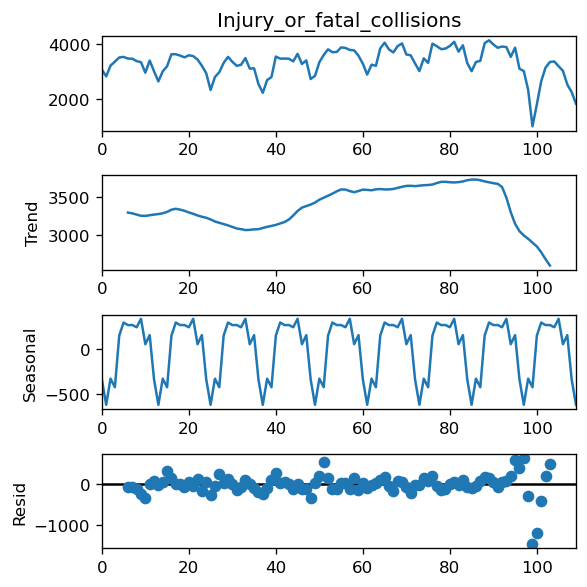

In [77]:
matplotlib.rcParams['figure.figsize'] = [5,5]
res = sm.tsa.seasonal_decompose(df_monthly['Injury_or_fatal_collisions'],model='additive',freq=12)
res.plot()
plt.show()

In [78]:
series = df_monthly['Injury_or_fatal_collisions'].diff().diff(12)
result = adfuller(series.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.907548
p-value: 0.000000


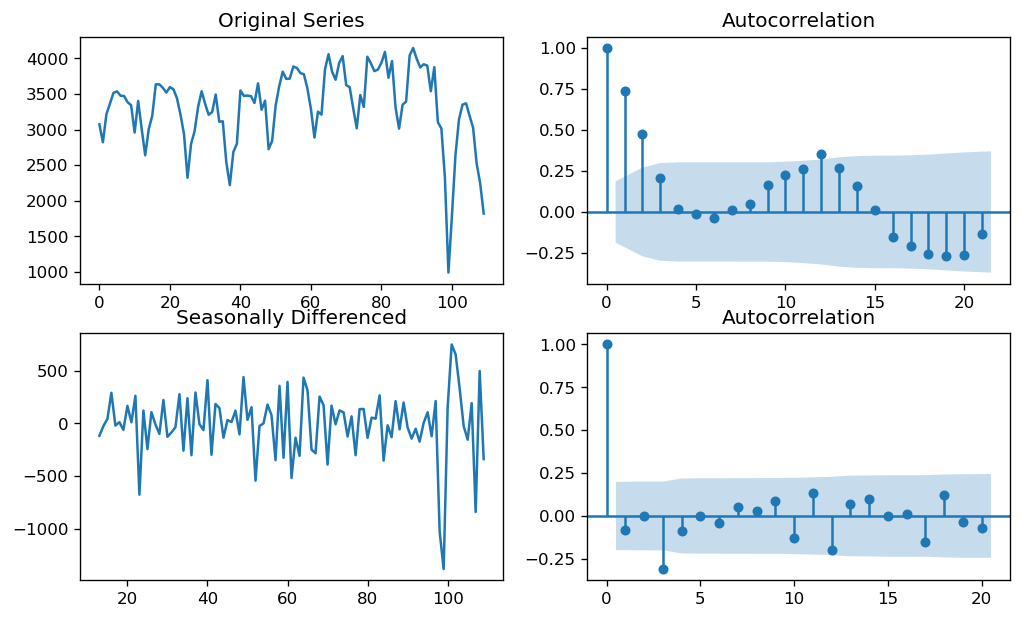

In [79]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(df_monthly['Injury_or_fatal_collisions']); axes[0, 0].set_title('Original Series')
plot_acf(df_monthly['Injury_or_fatal_collisions'].dropna(), ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(df_monthly['Injury_or_fatal_collisions'].diff().diff(12)); axes[1, 0].set_title('Seasonally Differenced')
plot_acf(df_monthly['Injury_or_fatal_collisions'].diff().diff(12).dropna(), ax=axes[1, 1])
plt.show()

In [80]:
import pmdarima as pm
model = pm.auto_arima(df_monthly['Injury_or_fatal_collisions'], d=1, D=1,
                      m=12, trend='c', seasonal=True, 
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1383.186, Time=0.26 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1394.125, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1389.408, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1383.275, Time=0.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1381.390, Time=0.14 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1382.845, Time=0.42 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1387.558, Time=0.11 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1383.287, Time=0.25 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1381.390, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12] intercept
Total fit time: 3.048 seconds


In [82]:
train=df_monthly[['Date','Injury_or_fatal_collisions']][:84]
valid=df_monthly[['Date','Injury_or_fatal_collisions']][84:96]
test=df_monthly[['Date','Injury_or_fatal_collisions']][96:]

In [84]:
model = SARIMAX(train['Injury_or_fatal_collisions'],order=(0,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:           Injury_or_fatal_collisions   No. Observations:                   84
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -473.716
Date:                              Tue, 27 Apr 2021   AIC                            951.433
Time:                                      16:13:01   BIC                            955.958
Sample:                                           0   HQIC                           953.232
                                               - 84                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9884      4.339     -0.228      0.820      -9.492       7.516
sigma2      2.654e+04   1.13e+05      0.234      0.815   -1.95e+05    2.49e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.60   Jarque-Bera (JB):                 0.59
Prob(Q):                              0.00   Prob(JB):                         0.74
Heteroskedasticity (H):               0.91   Skew:                            -0.01
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

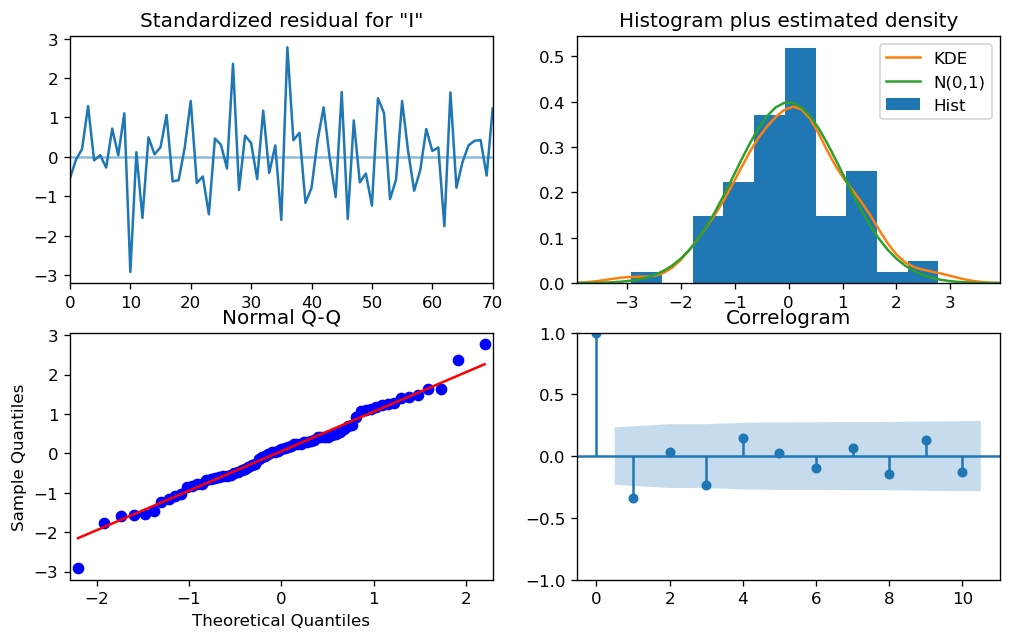

In [85]:
results.plot_diagnostics()
plt.show()

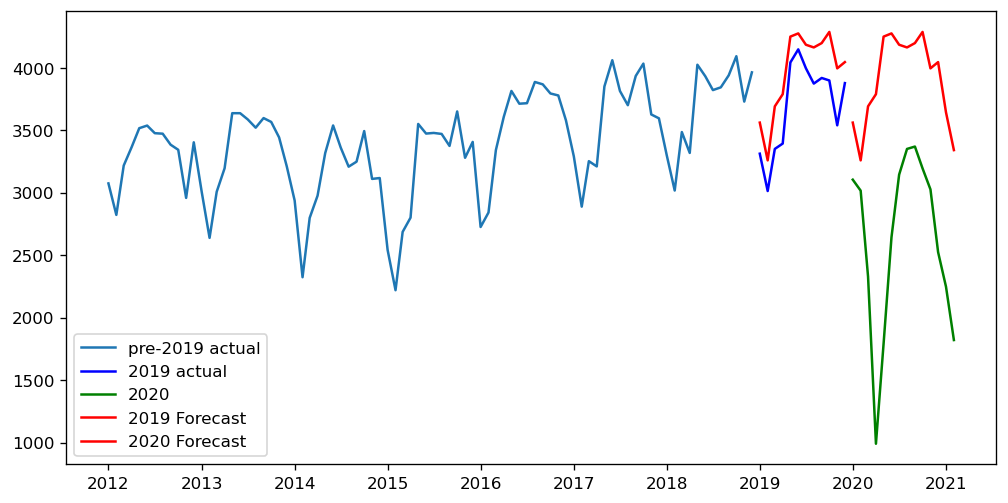

In [86]:
plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(pd.to_datetime(train.Date), train['Injury_or_fatal_collisions'],label='pre-2019 actual')
plt.plot(pd.to_datetime(valid.Date), valid['Injury_or_fatal_collisions'],color='blue',label='2019 actual')
plt.plot(pd.to_datetime(test.Date), test['Injury_or_fatal_collisions'],color='green',label='2020')
plt.plot(pd.to_datetime(valid.Date), results.forecast(steps=len(valid), alpha=0.05), label='2019 Forecast', color='red')
plt.plot(pd.to_datetime(test.Date), results.forecast(steps=len(test), alpha=0.05), label='2020 Forecast', color='red')
plt.legend(loc='lower left')

In [87]:
r2_score(valid['Injury_or_fatal_collisions'], results.forecast(steps=len(valid), alpha=0.05))

0.267828564375337

In [88]:
r2_score(test['Injury_or_fatal_collisions'], results.forecast(steps=len(test), alpha=0.05))

-3.6040873223593586

In [89]:
mean_absolute_percentage_error(valid['Injury_or_fatal_collisions'],results.forecast(steps=len(valid)))

7.678566905010488

In [90]:
mean_absolute_percentage_error(test['Injury_or_fatal_collisions'],results.forecast(steps=len(test)))

65.45833008225969

## Citywide Model MAPE 2019: 7.68%, 2020: 65.5%

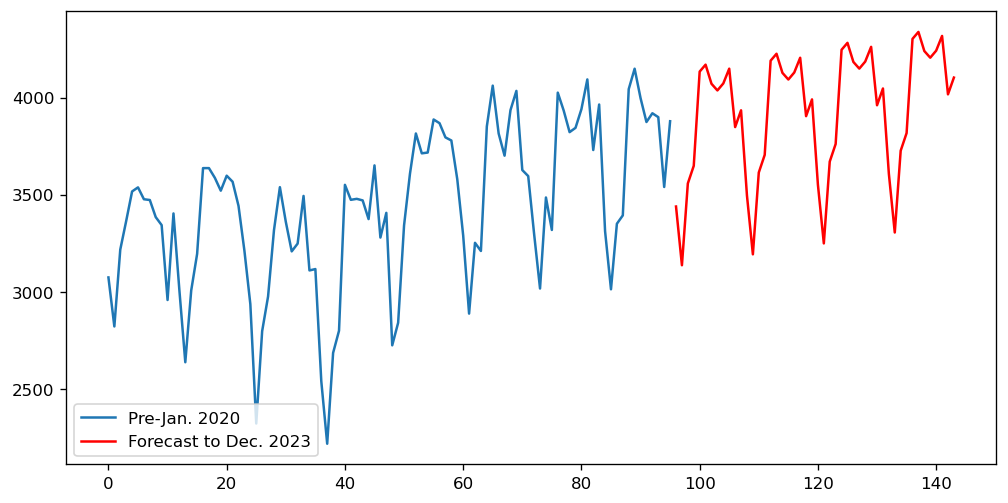

In [92]:
model2 = SARIMAX(df_monthly['Injury_or_fatal_collisions'][:96],order=(0,1,0),seasonal_order=(0,1,1,12))
results2 = model2.fit()

plt.rcParams.update({'figure.figsize':(10,5)})
plt.plot(df_monthly.index[:96], df_monthly['Injury_or_fatal_collisions'][:96],label='Pre-Jan. 2020')
plt.plot(x[96:], results2.forecast(steps=48, alpha=0.05), label='Forecast to Dec. 2023', color='red')
plt.legend(loc='lower left')

In [94]:
res=results2.forecast(24)
res[12:].mean()

3905.7666801831333

In [95]:
res=results2.forecast(36)
res[24:].mean()

3961.868329709048

In [96]:
res=results2.forecast(48)
res[36:].mean()

4017.969979234964

In [97]:
res=results2.forecast(60)
res[48:].mean()

4074.0716287608793

## Projected Avgs./Month/Year: 3906, 3962, 4018, 4074